# Churn Data

In [48]:
import pandas as pd
from src.cleaningfunctions import pipeline_clean2,pct
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

ImportError: cannot import name 'pct' from 'src.cleaningfunctions' (/Users/danielvega/galvanize/case_study/Churn/src/cleaningfunctions.py)

In [2]:
raw = pd.read_csv('data/churn_train.csv')

In [3]:
raw.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null object
phone                     39681 non-null object
signup_date               40000 non-null object
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.4+ MB


In [5]:
print(raw['avg_rating_of_driver'].mean())
print(raw['avg_rating_by_driver'].mean())

4.601696940726505
4.777433606104486


In [6]:
df = pipeline_clean2(raw)
print(df.head())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      40000 non-null float64
avg_rating_of_driver      40000 non-null float64
avg_surge                 40000 non-null float64
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
days_since_signup         40000 non-null int64
churned                   40000 non-null bool
Android                   40000 non-null uint8
No phone                  40000 non-null uint8
iPhone                    40000 non-null uint8
Astapor                   40000 non-null uint8
King's Landing            40000 non-null uint8
Winterfell                40000 non-null uint8
dtypes: bool(2), float64(6), int64(2), uint8(6)
memory usage: 2.7 MB


In [7]:
# df.to_pickle('data/cleandf.pkl')
X = df.drop(['churned'],axis=1)
y = df.churned

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=29)

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
gdbr = GradientBoostingClassifier(learning_rate=0.1,n_estimators=100, random_state=1)
gdbr.fit(X_train,y_train)
y_pred_gdbr = gdbr.predict(X_test)

%time
print('accuracy %s' % accuracy_score(y_test,y_pred_gdbr))
print(classification_report(y_test,y_pred_gdbr))
print(confusion_matrix(y_test,y_pred_gdbr))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
accuracy 0.7901666666666667
              precision    recall  f1-score   support

       False       0.75      0.66      0.70      4493
        True       0.81      0.87      0.84      7507

    accuracy                           0.79     12000
   macro avg       0.78      0.76      0.77     12000
weighted avg       0.79      0.79      0.79     12000

[[2973 1520]
 [ 998 6509]]


In [18]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500,max_depth=7,random_state=0,oob_score=True,n_jobs=-1)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

%time
print('accuracy %s' % accuracy_score(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))
print(confusion_matrix(y_test,y_pred_rf))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs
accuracy 0.7838333333333334
              precision    recall  f1-score   support

       False       0.76      0.61      0.68      4493
        True       0.79      0.89      0.84      7507

    accuracy                           0.78     12000
   macro avg       0.78      0.75      0.76     12000
weighted avg       0.78      0.78      0.78     12000

[[2755 1738]
 [ 856 6651]]


In [20]:
gdbr.feature_importances_[:5]

array([0.0200652 , 0.21667148, 0.01409668, 0.00330019, 0.18130154])

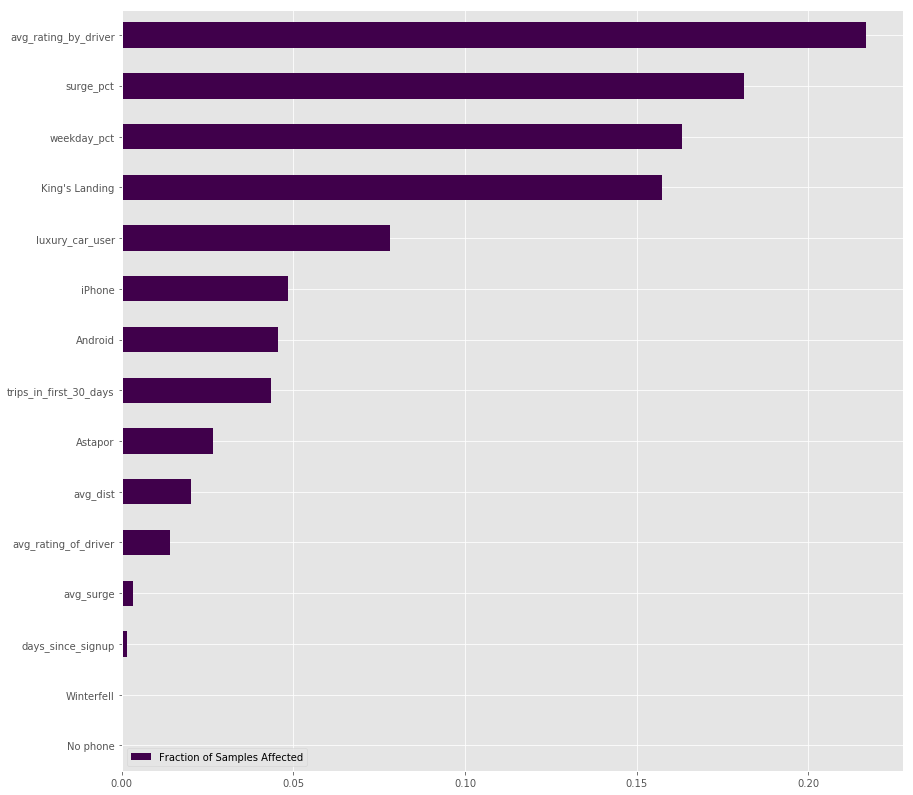

In [23]:
# Plot the feature importance
fig,ax = plt.subplots(figsize=(14,14))
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : gdbr.feature_importances_},
                          index=X_train.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh',ax=ax,fontsize=10,colormap='PRGn')

In [47]:
rf.feature_importances_[:5]

array([0.01870475, 0.19937952, 0.01249251, 0.09512284, 0.1503753 ])

In [55]:
X_train.columns[[1,3,4,7,13]]

Index(['avg_rating_by_driver', 'avg_surge', 'surge_pct', 'weekday_pct',
       'King's Landing'],
      dtype='object')

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

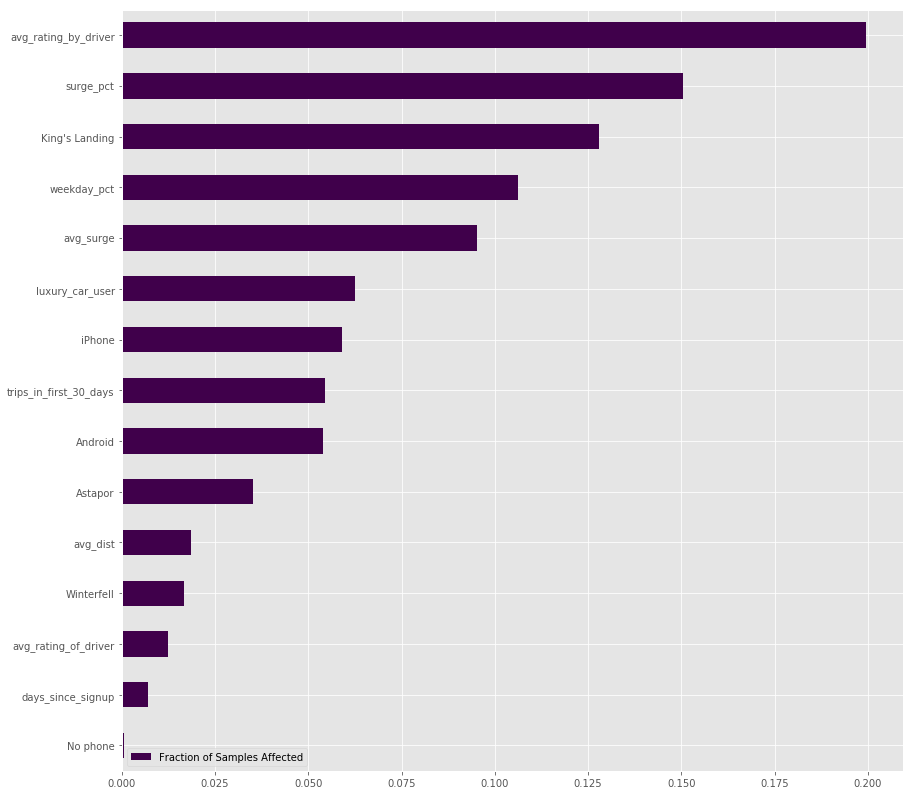

In [78]:
# Plot the feature importance
fig,ax = plt.subplots(figsize=(14,14))
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                          index=X_train.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh',ax=ax,fontsize=10,colormap='PRGn')

# fig.savefig('fi.png')

In [64]:
feat_scores[-5:]

,Fraction of Samples Affected
avg_surge,0.095123
weekday_pct,0.106089
King's Landing,0.127908
surge_pct,0.150375
avg_rating_by_driver,0.199380


In [ ]:
df_pipe = pipeline_clean(df)
X_train, X_cv, y_train, y_cv = split_data(df_pipe)

In [ ]:
grid = {
    'learning_rate': [.1, 0.05, 0.01],
    'max_depth': [6, 8, 10],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt', 'log2', None ],
    'n_estimators': [300, 1000],
    'subsample': [0.25, 0.5]
}

gbc_grid_cv = GridSearchCV(GradientBoostingClassifier(), grid, verbose=0, n_jobs=-1)
gbc_grid_cv.fit(X_train, y_train)
y_pred = gbc_grid_cv.predict(X_cv)
gbc_grid_cv.best_params_

In [45]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7396643182943516

In [25]:
import seaborn as sns

In [35]:
df2 = raw.copy()

In [36]:
df2.weekday_pct = df2.weekday_pct.apply(lambda x: pct(x))
df2.surge_pct = df2.surge_pct.apply(lambda x: pct(x))

In [27]:
df2.groupby('city').sum()['churned']

city
Astapor            9863.0
King's Landing     3031.0
Winterfell        12074.0
Name: churned, dtype: float64

In [28]:
df2.groupby('city').count()['churned']

city
Astapor           13236
King's Landing     8144
Winterfell        18620
Name: churned, dtype: int64

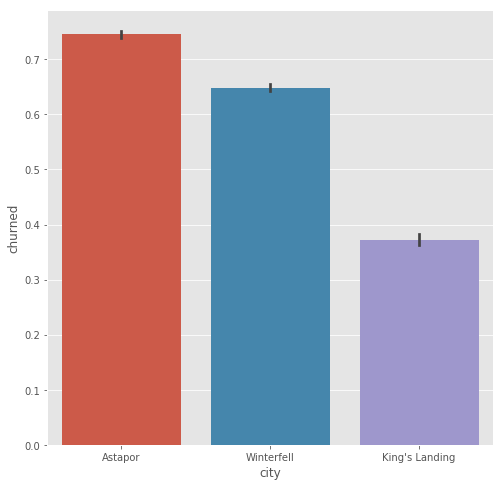

In [30]:
fig = plt.figure(figsize=(8,8))
sns.barplot(df2.city,df2.churned);
# fig.savefig('cities.png')

In [106]:
df2.city.value_counts()

Winterfell        18620
Astapor           13236
King's Landing     8144
Name: city, dtype: int64

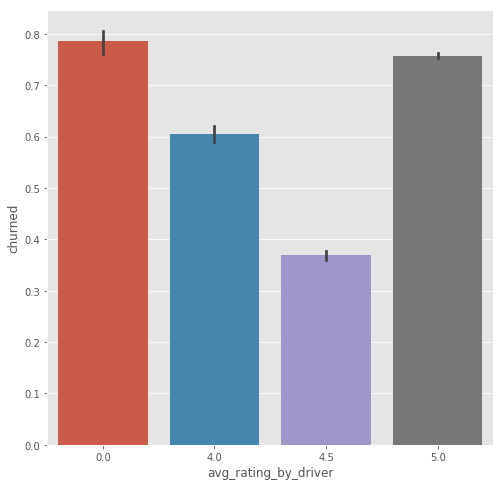

In [140]:
fig = plt.figure(figsize=(8,8))
sns.barplot(df2.avg_rating_by_driver,df2.churned)
# fig.savefig('rating_by_driver.png')

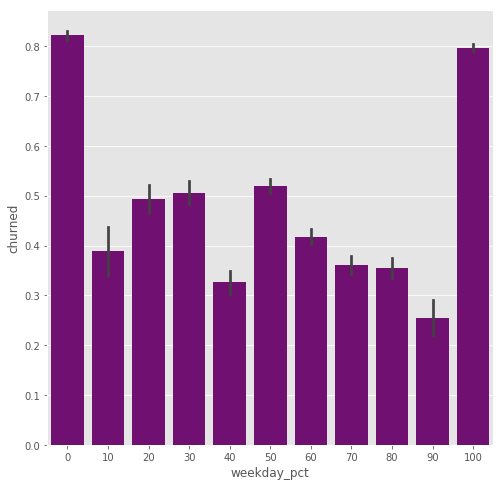

In [150]:
fig = plt.figure(figsize=(8,8))
sns.barplot(df2.weekday_pct,df2.churned,color='purple')
# fig.savefig('weekday.png')

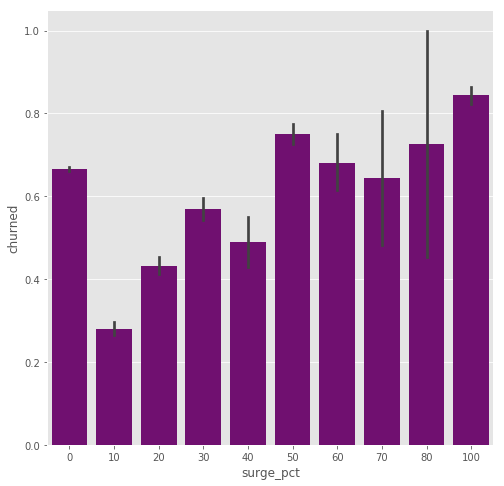

In [39]:
fig = plt.figure(figsize=(8,8))
sns.barplot(df2.surge_pct,df2.churned, color='purple');
# fig.savefig('surge_pct.png')

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


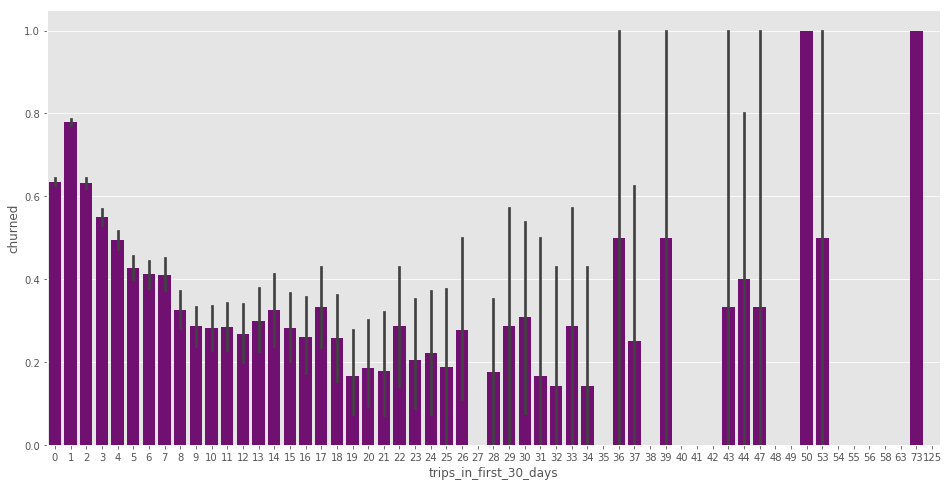

In [45]:
fig = plt.figure(figsize=(16,8))
sns.barplot(df2.trips_in_first_30_days,df2.churned, color='purple')